In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

bq_client = bigquery.Client()

# 2021 TD
start_date = '2021-01-01'
end_date = '2021-04-18'

sql = """
   WITH table AS (
      SELECT
          DFPI_DATE AS date,
          DFPI_customTargeting,
          DFPzone,
          DFPI_DeviceCategory,
          impressions,
          REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'jt=(.*?);') AS jt_values
      FROM
        `api-project-901373404215.DataMart.v_DFP_Revenue_Type2`
      WHERE
          DFPI_DATE BETWEEN '{}' AND '{}'
          AND REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'jt=(.*?);') IS NOT NULL
    )

    SELECT
        date,
        jt,
        DFPzone AS dfp_zone,
        DFPI_DeviceCategory AS device_category,
        SUM(impressions) AS jt_imps
    FROM (
        SELECT
            date,
            impressions,
            jt,
            DFPzone,
            DFPI_DeviceCategory
        FROM
            table
        CROSS JOIN
            UNNEST(jt_values) AS jt
        WHERE
            jt != '1.1'
        ORDER BY
            DFPI_customTargeting
    )
    GROUP BY
        date,
        jt,
        DFPzone,
        DFPI_DeviceCategory
    """.format(
    start_date,
    end_date
    )

df = bq_client.query(sql).to_dataframe()
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(19998, 5)


,date,jt,dfp_zone,device_category,jt_imps
0,2021-03-02,1.000,fdc.forbes:article-delta-g-finds-default-standard,Desktop,73
1,2021-03-02,1.000,fdcmobile:article-amp-masthead-default-standard,Tablet,70
2,2021-03-02,1.000,fdc.forbes:article-finds-default-standard,Desktop,2274
3,2021-03-02,1.000,fdcmobile:article-amp-topline-subscriber-standard,Smartphone,5
4,2021-03-02,1.000,fdc.forbes:article-delta-b-premium-nonsubscrib...,Desktop,6


In [47]:
sql_pipe = """
    SELECT 
        *
    FROM 
        `api-project-901373404215.fpd_imp.jt`
    WHERE 
        date BETWEEN '2021-01-01' AND '2021-04-18'
    """

df_pipe = bq_client.query(sql_pipe).to_dataframe()
df_pipe['date'] = pd.to_datetime(df_pipe['date'])
df_pipe['jt'] = df_pipe['jt'].astype(float)

print(df_pipe.shape)
df_pipe.head()

(22194, 5)


,date,jt,dfp_zone,device_category,jt_imps
0,2021-02-23,1.000,forbes:home,Tablet,173
1,2021-02-23,1.000,fdcmobile:article-premium-default-standard,Tablet,1
2,2021-02-23,1.000,fdc.forbes:article-delta-b-topline-default-sta...,Tablet,19
3,2021-02-23,1.000,fdcmobile:article-amp-standard-default-standard,Tablet,659
4,2021-02-23,1.000,forbes:video,Tablet,4


In [48]:
df['device_category'].value_counts()

Desktop          11079
Smartphone        4406
Tablet            4239
Connected TV       255
Feature Phone       19
Name: device_category, dtype: int64

In [49]:
df_pipe['device_category'].value_counts()

Desktop          12691
Tablet            4628
Smartphone        4561
Connected TV       293
Feature Phone       21
Name: device_category, dtype: int64

In [50]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df['device_category'] = df['device_category'].map(device_dict)
df2 = df.loc[df['device_category'].isin(['desktop', 'mobile'])]

# Filter for only c-level
df2 = df2.loc[df2['jt'] == 1]

# Pivot by device
device = pd.pivot_table(
    df2,
    index='date',
    columns='device_category',
    values='jt_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device['total'] = device['desktop'] + device['mobile']

device

device_category,date,desktop,mobile,total
0,2021-01-01,179472,240876,420348
1,2021-01-02,221211,247379,468590
2,2021-01-03,238767,249037,487804
3,2021-01-04,429212,250180,679392
4,2021-01-05,382830,270732,653562
...,...,...,...,...
103,2021-04-14,189037,2197,191234
104,2021-04-15,182685,2480,185165
105,2021-04-16,145539,7038,152577
106,2021-04-17,95961,20798,116759


In [51]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df_pipe['device_category'] = df_pipe['device_category'].map(device_dict)

df2_pipe = df_pipe.loc[df_pipe['device_category'].isin(['desktop', 'mobile'])]

# Filter for only c-level
df2_pipe = df2_pipe.loc[df2_pipe['jt'] == 1]

# Pivot by device
device_pipe = pd.pivot_table(
    df2_pipe,
    index='date',
    columns='device_category',
    values='jt_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device_pipe['total'] = device_pipe['desktop'] + device_pipe['mobile']

device_pipe

device_category,date,desktop,mobile,total
0,2021-01-01,179472,240876,420348
1,2021-01-02,221211,247379,468590
2,2021-01-03,238767,249037,487804
3,2021-01-04,429212,250180,679392
4,2021-01-05,382830,270732,653562
...,...,...,...,...
103,2021-04-14,378074,4394,382468
104,2021-04-15,365370,4960,370330
105,2021-04-16,291078,14076,305154
106,2021-04-17,191922,41596,233518


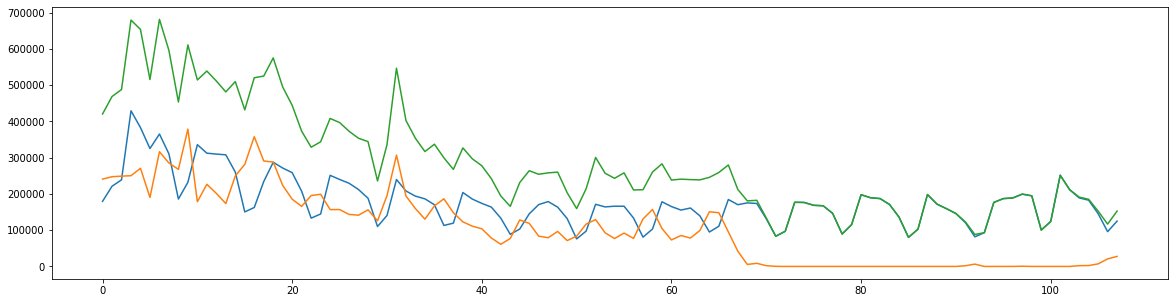

In [52]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device[['desktop','mobile', 'total']])
plt.show()

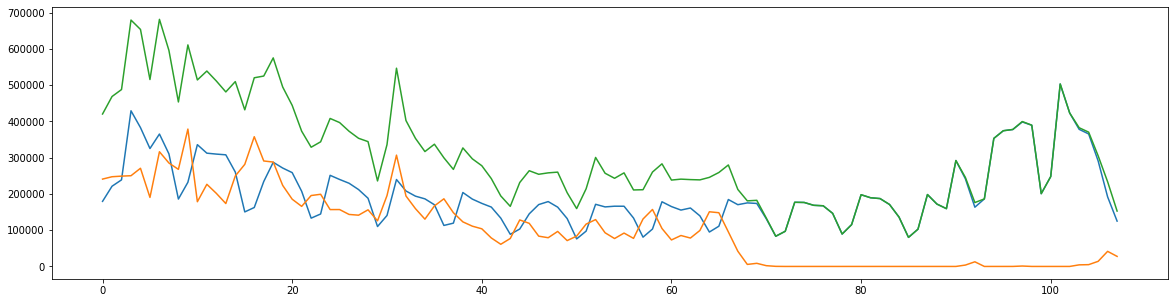

In [53]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device_pipe[['desktop','mobile', 'total']])
plt.show()

In [56]:
device.columns = ['date', 'desktop_orig', 'mobile_orig', 'total_orig']
device_pipe.columns = ['date', 'desktop_pipe', 'mobile_pipe', 'total_pipe']

df_comp = pd.merge(
    device,
    device_pipe,
    on='date',
    how='inner'
)

df_comp

,date,desktop_orig,mobile_orig,total_orig,desktop_pipe,mobile_pipe,total_pipe
0,2021-01-01,179472,240876,420348,179472,240876,420348
1,2021-01-02,221211,247379,468590,221211,247379,468590
2,2021-01-03,238767,249037,487804,238767,249037,487804
3,2021-01-04,429212,250180,679392,429212,250180,679392
4,2021-01-05,382830,270732,653562,382830,270732,653562
...,...,...,...,...,...,...,...
103,2021-04-14,189037,2197,191234,378074,4394,382468
104,2021-04-15,182685,2480,185165,365370,4960,370330
105,2021-04-16,145539,7038,152577,291078,14076,305154
106,2021-04-17,95961,20798,116759,191922,41596,233518


In [58]:
df_comp['diff_total'] = df_comp['total_pipe'] - df_comp['total_orig']
df_comp['diff_desktop'] = df_comp['desktop_pipe'] - df_comp['desktop_orig']
df_comp['diff_mobile'] = df_comp['mobile_pipe'] - df_comp['mobile_orig']
df_comp

,date,desktop_orig,mobile_orig,total_orig,desktop_pipe,mobile_pipe,total_pipe,diff_total,diff_desktop,diff_mobile
0,2021-01-01,179472,240876,420348,179472,240876,420348,0,0,0
1,2021-01-02,221211,247379,468590,221211,247379,468590,0,0,0
2,2021-01-03,238767,249037,487804,238767,249037,487804,0,0,0
3,2021-01-04,429212,250180,679392,429212,250180,679392,0,0,0
4,2021-01-05,382830,270732,653562,382830,270732,653562,0,0,0
...,...,...,...,...,...,...,...,...,...,...
103,2021-04-14,189037,2197,191234,378074,4394,382468,191234,189037,2197
104,2021-04-15,182685,2480,185165,365370,4960,370330,185165,182685,2480
105,2021-04-16,145539,7038,152577,291078,14076,305154,152577,145539,7038
106,2021-04-17,95961,20798,116759,191922,41596,233518,116759,95961,20798


In [59]:
# Save to csv
df_comp.to_csv('jt_comp.csv', index=False)

In [60]:
# HI
sql = """
    WITH table AS (
      SELECT
          DFPI_DATE AS date,
          DFPI_customTargeting,
          DFPzone,
          DFPI_DeviceCategory,
          impressions,
          REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'hi=(.*?);') AS hi_values
      FROM
        `api-project-901373404215.DataMart.v_DFP_Revenue_Type2`
      WHERE
          DFPI_DATE BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
          AND REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'hi=(.*?);') IS NOT NULL
    )

    SELECT
        date,
        hi,
        DFPzone AS dfp_zone,
        DFPI_DeviceCategory AS device_category,
        SUM(impressions) AS hi_imps
    FROM (
        SELECT
            date,
            impressions,
            hi,
            DFPzone,
            DFPI_DeviceCategory
        FROM
            table
        CROSS JOIN
            UNNEST(hi_values) AS hi
        ORDER BY
            DFPI_customTargeting
    )
    GROUP BY
        date,
        hi,
        DFPzone,
        DFPI_DeviceCategory
    """

df = bq_client.query(sql).to_dataframe()
df['date'] = pd.to_datetime(df['date'])
df['hi'] = df['hi'].astype(float)

print(df.shape)
df.head()

(116288, 5)


,date,hi,dfp_zone,device_category,hi_imps
0,2021-03-02,5.000,fdc.forbes:article-delta-d-standard-subscriber...,Desktop,20
1,2021-03-02,4.000,fdc.forbes:article-blue-delta-g-standard-defau...,Desktop,28
2,2021-03-02,3.000,fdc.forbes:article-finds-default-standard,Connected TV,65
3,2021-03-02,2.000,fdc.forbes:article-delta-g-finds-default-standard,Tablet,27
4,2021-03-02,6.000,fdc.forbes:article-live-default-standard,Desktop,312


In [61]:
sql_pipe = """
    SELECT 
        *
    FROM 
        `api-project-901373404215.fpd_imp.hi`
    WHERE 
        date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
    """

df_pipe = bq_client.query(sql_pipe).to_dataframe()
df_pipe['date'] = pd.to_datetime(df_pipe['date'])
df_pipe['hi'] = df_pipe['hi'].astype(float)

print(df_pipe.shape)
df_pipe.head()

(116288, 5)


,date,hi,dfp_zone,device_category,hi_imps
0,2021-04-18,7.000,forbes:home,Tablet,6
1,2021-04-18,1.000,forbes:home,Tablet,6
2,2021-04-18,6.000,forbes:home,Tablet,9
3,2021-04-18,5.000,forbes:home,Tablet,320
4,2021-04-18,3.000,forbes:home,Tablet,481


In [62]:
df['device_category'].value_counts()

Desktop          68091
Tablet           25471
Smartphone       17723
Connected TV      4577
Feature Phone      426
Name: device_category, dtype: int64

In [63]:
df_pipe['device_category'].value_counts()

Desktop          68091
Tablet           25471
Smartphone       17723
Connected TV      4577
Feature Phone      426
Name: device_category, dtype: int64

In [64]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df['device_category'] = df['device_category'].map(device_dict)
df2 = df.loc[df['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device = pd.pivot_table(
    df2,
    index='date',
    columns='device_category',
    values='hi_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device['total'] = device['desktop'] + device['mobile']

device

device_category,date,desktop,mobile,total
0,2021-01-26,11227051,7363352,18590403
1,2021-01-27,11223069,7629005,18852074
2,2021-01-28,10774872,7919942,18694814
3,2021-01-29,10004264,7962117,17966381
4,2021-01-30,6820050,6573501,13393551
...,...,...,...,...
86,2021-04-22,6989444,4460256,11449700
87,2021-04-23,6790104,4850174,11640278
88,2021-04-24,4397747,4001288,8399035
89,2021-04-25,5554442,4479845,10034287


In [65]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df_pipe['device_category'] = df_pipe['device_category'].map(device_dict)

df2_pipe = df_pipe.loc[df_pipe['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device_pipe = pd.pivot_table(
    df2_pipe,
    index='date',
    columns='device_category',
    values='hi_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device_pipe['total'] = device_pipe['desktop'] + device_pipe['mobile']

device_pipe

device_category,date,desktop,mobile,total
0,2021-01-26,11227051,7363352,18590403
1,2021-01-27,11223069,7629005,18852074
2,2021-01-28,10774872,7919942,18694814
3,2021-01-29,10004264,7962117,17966381
4,2021-01-30,6820050,6573501,13393551
...,...,...,...,...
86,2021-04-22,6989444,4460256,11449700
87,2021-04-23,6790104,4850174,11640278
88,2021-04-24,4397747,4001288,8399035
89,2021-04-25,5554442,4479845,10034287


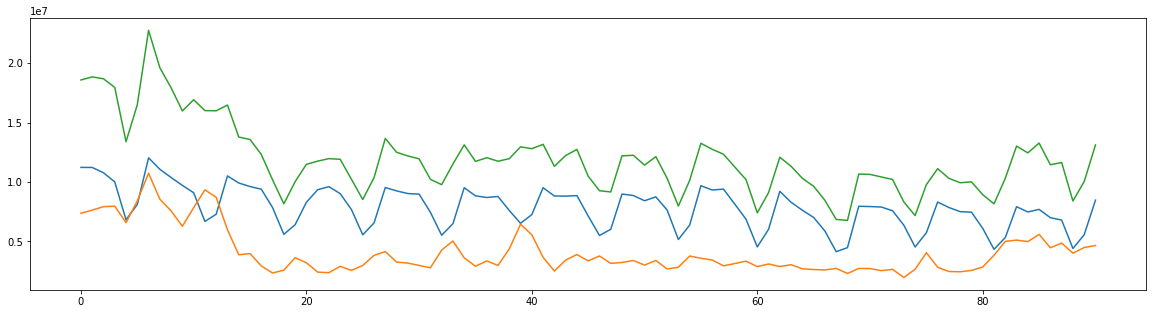

In [66]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device[['desktop','mobile', 'total']])
plt.show()

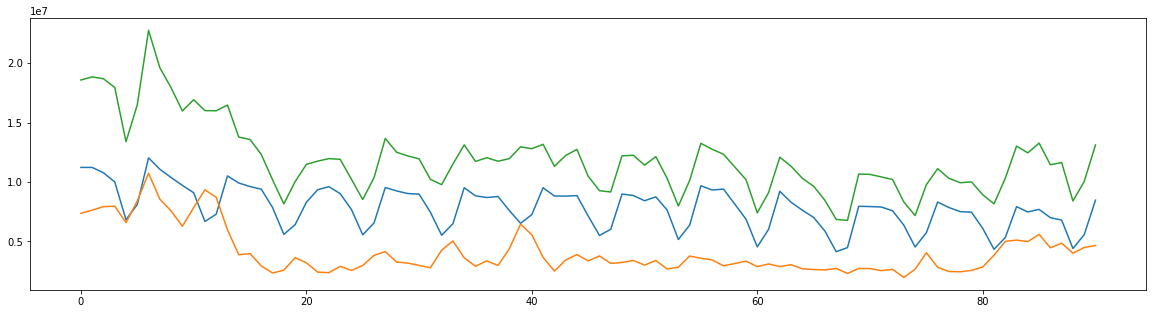

In [67]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device_pipe[['desktop','mobile', 'total']])
plt.show()

In [68]:
# AA
sql = """
    WITH table AS (
      SELECT
          DFPI_DATE AS date,
          DFPI_customTargeting,
          DFPzone,
          DFPI_DeviceCategory,
          impressions,
          REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'fbs-aa=(.*?);') AS fbs_aa_values
      FROM
        `api-project-901373404215.DataMart.v_DFP_Revenue_Type2`
      WHERE
          DFPI_DATE BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
          AND REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'fbs-aa=(.*?);') IS NOT NULL
    )

    SELECT
        date,
        fbs_aa,
        DFPzone AS dfp_zone,
        DFPI_DeviceCategory AS device_category,
        SUM(impressions) AS fbs_aa_imps
    FROM (
        SELECT
            date,
            impressions,
            fbs_aa,
            DFPzone,
            DFPI_DeviceCategory
        FROM
            table
        CROSS JOIN
            UNNEST(fbs_aa_values) AS fbs_aa
        ORDER BY
            DFPI_customTargeting
    )
    GROUP BY
        date,
        fbs_aa,
        DFPzone,
        DFPI_DeviceCategory
    """

df = bq_client.query(sql).to_dataframe()
df['date'] = pd.to_datetime(df['date'])
df['fbs_aa'] = df['fbs_aa'].astype(float)

print(df.shape)
df.head()

(64799, 5)


,date,fbs_aa,dfp_zone,device_category,fbs_aa_imps
0,2021-03-02,4.000,fdc.forbes:article-standard-subscriber-alx,Desktop,254
1,2021-03-02,4.000,forbes:companies,Desktop,39
2,2021-03-02,3.000,fdc.forbes:article-delta-c-standard-default-st...,Tablet,7
3,2021-03-02,5.000,fdc.forbes:article-delta-c-standard-default-st...,Tablet,15
4,2021-03-02,7.000,fdc.forbes:article-delta-c-masthead-default-st...,Desktop,11


In [69]:
sql_pipe = """
    SELECT 
        *
    FROM 
        `api-project-901373404215.fpd_imp.fbs_aa`
    WHERE 
        date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
    """

df_pipe = bq_client.query(sql_pipe).to_dataframe()
df_pipe['date'] = pd.to_datetime(df_pipe['date'])
df_pipe['fbs_aa'] = df_pipe['fbs_aa'].astype(float)

print(df_pipe.shape)
df_pipe.head()

(64799, 5)


,date,fbs_aa,dfp_zone,device_category,fbs_aa_imps
0,2021-02-11,2.000,forbes:home,Tablet,65
1,2021-02-11,3.000,forbes:home,Tablet,235
2,2021-02-11,5.000,forbes:home,Tablet,70
3,2021-02-11,6.000,forbes:home,Tablet,151
4,2021-02-11,4.000,forbes:home,Tablet,7


In [70]:
df['device_category'].value_counts()

Desktop          43116
Tablet           12332
Smartphone        8677
Connected TV       654
Feature Phone       20
Name: device_category, dtype: int64

In [71]:
df_pipe['device_category'].value_counts()

Desktop          43116
Tablet           12332
Smartphone        8677
Connected TV       654
Feature Phone       20
Name: device_category, dtype: int64

In [73]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df['device_category'] = df['device_category'].map(device_dict)
df2 = df.loc[df['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device = pd.pivot_table(
    df2,
    index='date',
    columns='device_category',
    values='fbs_aa_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device['total'] = device['desktop'] + device['mobile']

device

device_category,date,desktop,mobile,total
0,2021-01-26,688924,219327,908251
1,2021-01-27,688723,189436,878159
2,2021-01-28,664823,225658,890481
3,2021-01-29,639524,234869,874393
4,2021-01-30,386796,174182,560978
...,...,...,...,...
86,2021-04-22,441826,149160,590986
87,2021-04-23,414414,129904,544318
88,2021-04-24,231634,99127,330761
89,2021-04-25,278799,144176,422975


In [74]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df_pipe['device_category'] = df_pipe['device_category'].map(device_dict)

df2_pipe = df_pipe.loc[df_pipe['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device_pipe = pd.pivot_table(
    df2_pipe,
    index='date',
    columns='device_category',
    values='fbs_aa_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device_pipe['total'] = device_pipe['desktop'] + device_pipe['mobile']

device_pipe

device_category,date,desktop,mobile,total
0,2021-01-26,688924,219327,908251
1,2021-01-27,688723,189436,878159
2,2021-01-28,664823,225658,890481
3,2021-01-29,639524,234869,874393
4,2021-01-30,386796,174182,560978
...,...,...,...,...
86,2021-04-22,441826,149160,590986
87,2021-04-23,414414,129904,544318
88,2021-04-24,231634,99127,330761
89,2021-04-25,278799,144176,422975


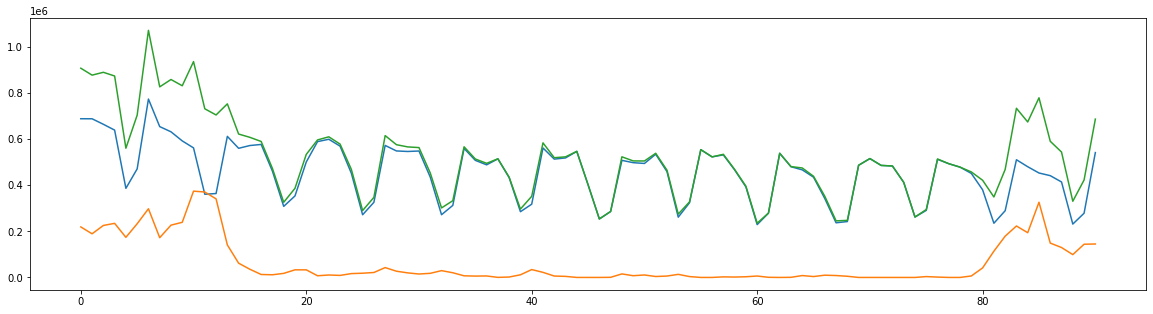

In [75]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device[['desktop','mobile', 'total']])
plt.show()

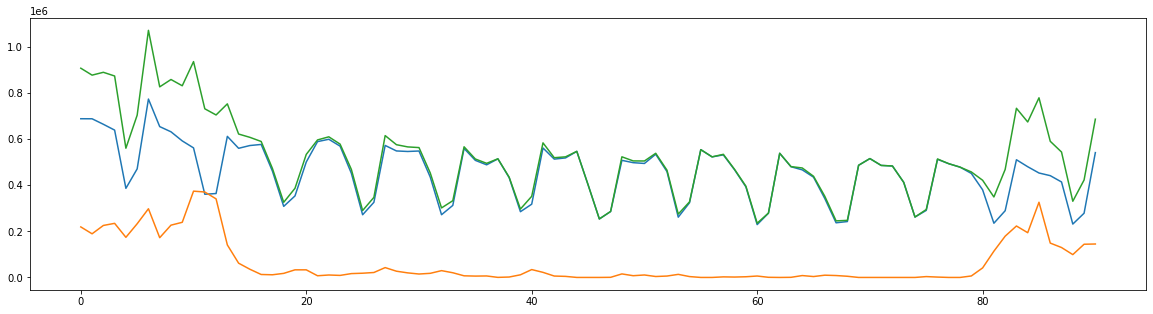

In [76]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device_pipe[['desktop','mobile', 'total']])
plt.show()

In [4]:
# DM
sql = """
    WITH table AS (
      SELECT
          DFPI_DATE AS date,
          DFPI_customTargeting,
          DFPzone,
          DFPI_DeviceCategory,
          impressions,
          REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'fbs-dm=(.*?);') AS dm_values
      FROM
        `api-project-901373404215.DataMart.v_DFP_Revenue_Type2`
      WHERE
          DFPI_DATE BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
          AND REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'fbs-dm=(.*?);') IS NOT NULL
    )

    SELECT
        date,
        dm,
        DFPzone AS dfp_zone,
        DFPI_DeviceCategory AS device_category,
        SUM(impressions) AS dm_imps
    FROM (
        SELECT
            date,
            impressions,
            dm,
            DFPzone,
            DFPI_DeviceCategory
        FROM
            table
        CROSS JOIN
            UNNEST(dm_values) AS dm
        ORDER BY
            DFPI_customTargeting
    )
    GROUP BY
        date,
        dm,
        DFPzone,
        DFPI_DeviceCategory
    """

df = bq_client.query(sql).to_dataframe()

df['date'] = pd.to_datetime(df['date'])
df['dm'] = df['dm'].astype(float)

print(df.shape)
df.head()

(35674, 5)


,date,dm,dfp_zone,device_category,dm_imps
0,2021-03-02,2.000,fdc.forbes:article-finds-default-standard,Desktop,1244
1,2021-03-02,2.000,forbes:contribhome,Desktop,6397
2,2021-03-02,1.000,fdc.forbes:article-topline-default-standard,Tablet,1475
3,2021-03-02,3.000,fdc.forbes:article-premium-nonsubscriber-standard,Desktop,82
4,2021-03-02,3.000,fdcmobile:companies,Smartphone,5


In [12]:
sql_pipe = """
    SELECT 
        *
    FROM 
        `api-project-901373404215.fpd_imp.fbs_dm`
    WHERE 
        date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
    """

df_pipe = bq_client.query(sql_pipe).to_dataframe()
df_pipe['date'] = pd.to_datetime(df_pipe['date'])
df_pipe['dm'] = df_pipe['dm'].astype(float)

print(df_pipe.shape)
df_pipe.head()

(35674, 5)


,date,dm,dfp_zone,device_category,fuse_imps
0,2021-04-15,1.000,forbes:home,Tablet,192
1,2021-04-15,3.000,forbes:home,Tablet,74
2,2021-04-15,2.000,forbes:home,Tablet,184
3,2021-04-15,3.000,forbes:channel,Tablet,24
4,2021-04-15,2.000,forbes:channel,Tablet,24


In [7]:
df['device_category'].value_counts()

Desktop          24984
Tablet            6047
Smartphone        4343
Connected TV       287
Feature Phone       13
Name: device_category, dtype: int64

In [8]:
df_pipe['device_category'].value_counts()

Desktop          24984
Tablet            6047
Smartphone        4343
Connected TV       287
Feature Phone       13
Name: device_category, dtype: int64

In [ ]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df['device_category'] = df['device_category'].map(device_dict)
df2 = df.loc[df['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device = pd.pivot_table(
    df2,
    index='date',
    columns='device_category',
    values='fuse_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device['total'] = device['desktop'] + device['mobile']

device

In [13]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df_pipe['device_category'] = df_pipe['device_category'].map(device_dict)

df2_pipe = df_pipe.loc[df_pipe['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device_pipe = pd.pivot_table(
    df2_pipe,
    index='date',
    columns='device_category',
    values='fuse_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device_pipe['total'] = device_pipe['desktop'] + device_pipe['mobile']

device_pipe

device_category,date,desktop,mobile,total
0,2021-01-27,611526,98213,709739
1,2021-01-28,608572,129878,738450
2,2021-01-29,494368,86153,580521
3,2021-01-30,257288,73876,331164
4,2021-01-31,335559,90622,426181
...,...,...,...,...
86,2021-04-23,445159,75455,520614
87,2021-04-24,217183,39625,256808
88,2021-04-25,283804,48508,332312
89,2021-04-26,588572,84777,673349


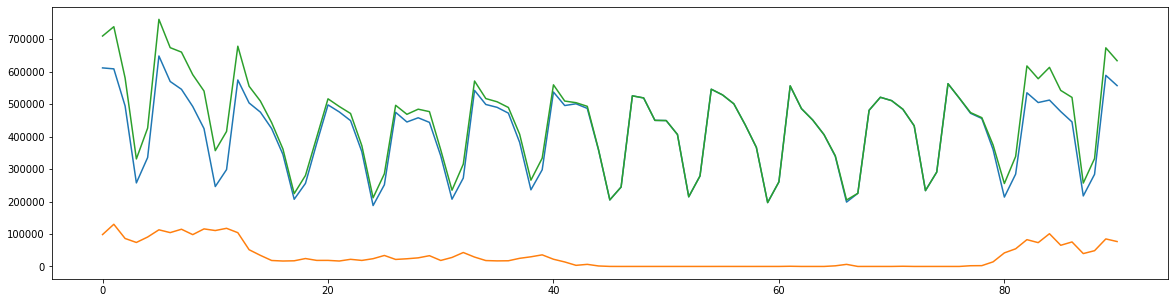

In [14]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device[['desktop','mobile', 'total']])
plt.show()

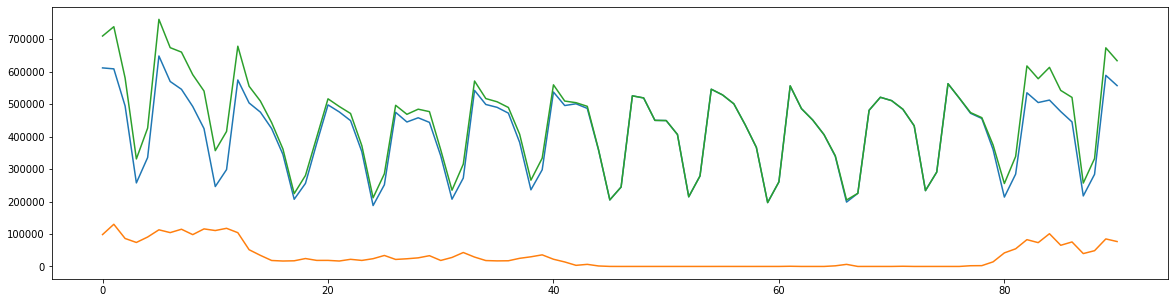

In [15]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device_pipe[['desktop','mobile', 'total']])
plt.show()

In [3]:
# FUSE2
sql = """
    WITH table AS (
      SELECT
          DFPI_DATE AS date,
          DFPI_customTargeting,
          DFPzone,
          DFPI_DeviceCategory,
          impressions,
          REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'fuse2=(.*?);') AS fuse2_values
      FROM
        `api-project-901373404215.DataMart.v_DFP_Revenue_Type2`
      WHERE
          DFPI_DATE BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
          AND REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'fuse2=(.*?);') IS NOT NULL
    )

    SELECT
        date,
        fuse2,
        DFPzone AS dfp_zone,
        DFPI_DeviceCategory AS device_category,
        SUM(impressions) AS fuse2_imps
    FROM (
        SELECT
            date,
            impressions,
            fuse2,
            DFPzone,
            DFPI_DeviceCategory
        FROM
            table
        CROSS JOIN
            UNNEST(fuse2_values) AS fuse2
        ORDER BY
            DFPI_customTargeting
    )
    GROUP BY
        date,
        fuse2,
        DFPzone,
        DFPI_DeviceCategory
    """

df = bq_client.query(sql).to_dataframe()
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(2365255, 5)


,date,fuse2,dfp_zone,device_category,fuse2_imps
0,2021-03-02,28.2.2,forbes:profile,Desktop,475
1,2021-03-02,9.5,forbes:channel,Desktop,1471
2,2021-03-02,16,fdc.forbes:article-premium-default-standard,Desktop,2790
3,2021-03-02,3.1.4,fdc.forbes:article-standard-nonsubscriber-stan...,Desktop,298
4,2021-03-02,4.4,fdc.forbes:article-masthead-default-standard,Desktop,885


In [4]:
sql_pipe = """
    SELECT 
        *
    FROM
        `api-project-901373404215.fpd_imp.fuse2`
    WHERE 
        date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 91 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
    """

df_pipe = bq_client.query(sql_pipe).to_dataframe()
df_pipe['date'] = pd.to_datetime(df_pipe['date'])

print(df_pipe.shape)
df_pipe.head()

(2365255, 5)


,date,fuse2,dfp_zone,device_category,fuse_imps
0,2021-04-17,cc.2,forbes:video,Desktop,24
1,2021-02-12,6.5,forbes:home,Desktop,46
2,2021-02-12,7.6.4,forbes:home,Desktop,58
3,2021-02-12,7,forbes:home,Desktop,1406
4,2021-02-12,9.11,forbes:home,Desktop,203


In [5]:
df['device_category'].value_counts()

Desktop          1770267
Tablet            315398
Smartphone        271072
Connected TV        8019
Feature Phone        499
Name: device_category, dtype: int64

In [6]:
df_pipe['device_category'].value_counts()

Desktop          1770267
Tablet            315398
Smartphone        271072
Connected TV        8019
Feature Phone        499
Name: device_category, dtype: int64

In [9]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df['device_category'] = df['device_category'].map(device_dict)
df2 = df.loc[df['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device = pd.pivot_table(
    df2,
    index='date',
    columns='device_category',
    values='fuse2_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device['total'] = device['desktop'] + device['mobile']

device

device_category,date,desktop,mobile,total
0,2021-01-27,10832160,2432646,13264806
1,2021-01-28,10233999,2311866,12545865
2,2021-01-29,9544743,2850631,12395374
3,2021-01-30,4770074,2062490,6832564
4,2021-01-31,5804298,3270692,9074990
...,...,...,...,...
86,2021-04-23,11641345,1965855,13607200
87,2021-04-24,5799313,1476117,7275430
88,2021-04-25,7309989,2381006,9690995
89,2021-04-26,15284191,2263355,17547546


In [11]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df_pipe['device_category'] = df_pipe['device_category'].map(device_dict)

df2_pipe = df_pipe.loc[df_pipe['device_category'].isin(['desktop', 'mobile'])]

# Pivot by device
device_pipe = pd.pivot_table(
    df2_pipe,
    index='date',
    columns='device_category',
    values='fuse_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device_pipe['total'] = device_pipe['desktop'] + device_pipe['mobile']

device_pipe

device_category,date,desktop,mobile,total
0,2021-01-27,10832160,2432646,13264806
1,2021-01-28,10233999,2311866,12545865
2,2021-01-29,9544743,2850631,12395374
3,2021-01-30,4770074,2062490,6832564
4,2021-01-31,5804298,3270692,9074990
...,...,...,...,...
86,2021-04-23,11641345,1965855,13607200
87,2021-04-24,5799313,1476117,7275430
88,2021-04-25,7309989,2381006,9690995
89,2021-04-26,15284191,2263355,17547546


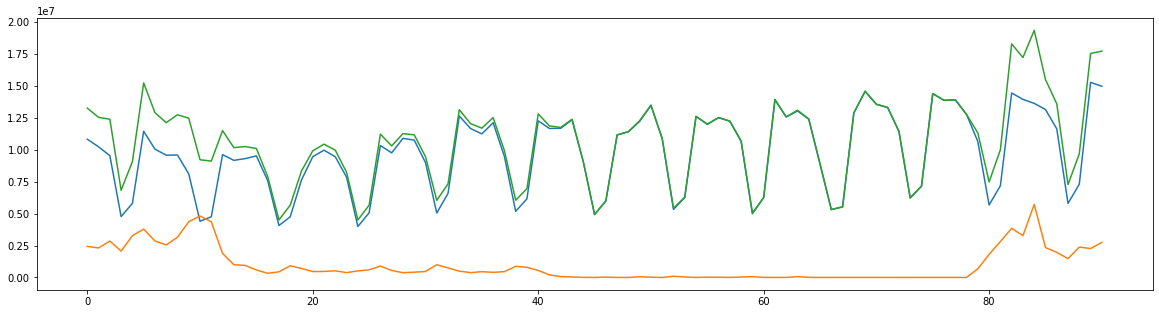

In [12]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device[['desktop','mobile', 'total']])
plt.show()

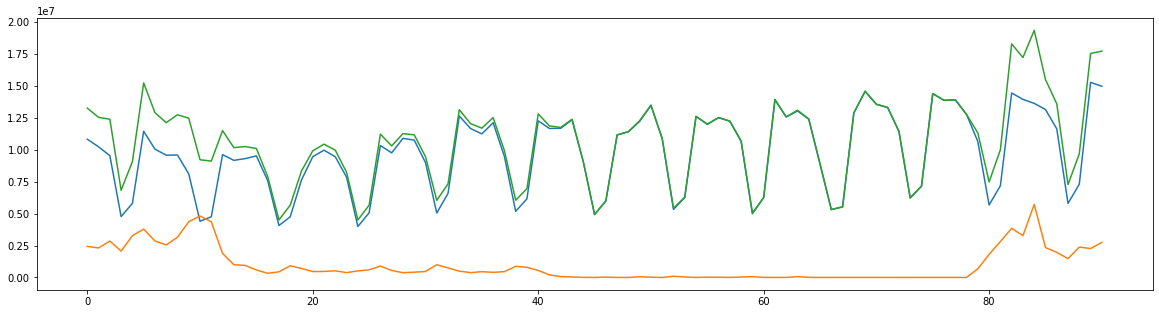

In [13]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device_pipe[['desktop','mobile', 'total']])
plt.show()